# Phase 3: Model & Strategy Comparison
This phase compares different classifiers (Logistic Regression, SVM, Naive Bayes) and tests the hypothesis of grouped vs. all classes for both clarity_label and evasion_label.

## Imports & Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from src.preprocessing import get_preprocessed_data
from src.evaluate import run_full_evaluation

SEED = 42
np.random.seed(SEED)

# Load data
train_df, val_df, test_df, id2label, label2id = get_preprocessed_data()

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")
print(f"Evasion labels: {id2label}")

Train: 2758, Val: 690, Test: 308
Evasion labels: {0: 'Claims ignorance', 1: 'Clarification', 2: 'Declining to answer', 3: 'Deflection', 4: 'Dodging', 5: 'Explicit', 6: 'General', 7: 'Implicit', 8: 'Partial/half-answer'}


## Helper Functions for Grouping Labels

In [2]:
def group_evasion_labels(series, id2label):
    """
    Group evasion labels into 3 main classes:
    - Clear: Explicit
    - Ambivalent Reply: General, Implicit, Dodging, Deflection
    - Clear non-reply: Claims ignorance, Clarification, Declining to answer
    - Partial/half-answer: Partial/half-answer
    """
    # First convert integers back to string labels
    string_labels = series.map(id2label)
    
    # Then apply grouping mapping
    mapping = {
        'Explicit': 'Clear',
        'General': 'Ambivalent Reply',
        'Implicit': 'Ambivalent Reply',
        'Dodging': 'Ambivalent Reply',
        'Claims ignorance': 'Clear non-reply',
        'Clarification': 'Clear non-reply',
        'Declining to answer': 'Clear non-reply',
        'Partial/half-answer': 'Ambivalent Reply',
        'Deflection': 'Ambivalent Reply',
    }
    return string_labels.map(mapping)

# Create grouped versions
for df in [train_df, val_df, test_df]:
    df['evasion_label_grouped'] = group_evasion_labels(df['evasion_label'], id2label)

print("Evasion label distribution (all classes):")
print(train_df['evasion_label'].value_counts())
print("\nEvasion label distribution (grouped):")
print(train_df['evasion_label_grouped'].value_counts())

Evasion label distribution (all classes):
evasion_label
5    841
4    565
7    390
6    309
3    305
2    116
0     95
1     74
8     63
Name: count, dtype: int64

Evasion label distribution (grouped):
evasion_label_grouped
Ambivalent Reply    1632
Clear                841
Clear non-reply      285
Name: count, dtype: int64


## Prepare Best Features from Phase 2
Based on Phase 2 results, we use:
- Sub-question + Answer context
- Meta-features (multiple_questions, affirmative_questions, inaudible)
- Trigrams (1, 3) which performed best

In [3]:
# Create contextual features
for df in [train_df, val_df, test_df]:
    df['sub_q_context'] = df['question'].fillna('') + " [SEP] " + df['interview_answer'].fillna('')
    
meta_cols = ['multiple_questions', 'affirmative_questions', 'inaudible']
for df in [train_df, val_df, test_df]:
    for col in meta_cols:
        df[col] = df[col].astype(int)

print("Features prepared!")

Features prepared!


## Experiment Runner Function

In [4]:
def run_classifier_experiment(
    clf_name,
    vectorizer_name,
    label_column,
    train_df,
    val_df,
    use_meta_features=True,
    ngram_range=(1, 2)
):
    """
    Run a single classifier experiment
    
    Parameters:
    - clf_name: 'logistic', 'svm', or 'naive_bayes'
    - vectorizer_name: 'tfidf' or 'count'
    - label_column: 'clarity_label', 'evasion_label', or 'evasion_label_grouped'
    - use_meta_features: whether to include meta-features
    - ngram_range: tuple for n-gram range
    """
    
    # Get labels
    y_train = train_df[label_column]
    y_val = val_df[label_column]
    
    # Build vectorizer
    vec_params = {
        'max_features': 2000,
        'ngram_range': ngram_range,
        'min_df': 2,
        'max_df': 0.95
    }
    
    if vectorizer_name == 'tfidf':
        vectorizer = TfidfVectorizer(**vec_params)
    else:  # count
        vectorizer = CountVectorizer(**vec_params)
    
    # Build classifier
    if clf_name == 'logistic':
        classifier = LogisticRegression(max_iter=1000, multi_class="multinomial", random_state=SEED)
    elif clf_name == 'svm':
        classifier = LinearSVC(max_iter=2000, class_weight='balanced', random_state=SEED, dual='auto')
    else:  # naive_bayes
        classifier = MultinomialNB()
    
    # Build pipeline
    if use_meta_features:
        preprocessor = ColumnTransformer(
            transformers=[
                ('text', vectorizer, 'sub_q_context'),
                ('meta', 'passthrough', meta_cols)
            ]
        )
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', classifier)
        ])
        X_train = train_df
        X_val = val_df
    else:
        X_train_text = train_df['sub_q_context']
        X_val_text = val_df['sub_q_context']
        X_train = vectorizer.fit_transform(X_train_text)
        X_val = vectorizer.transform(X_val_text)
        pipeline = classifier
    
    # Train
    pipeline.fit(X_train, y_train)
    
    # Predict
    y_pred = pipeline.predict(X_val)
    
    # Calculate metrics
    metrics = {
        'classifier': clf_name,
        'vectorizer': vectorizer_name,
        'label_column': label_column,
        'use_meta': use_meta_features,
        'f1_macro': f1_score(y_val, y_pred, average='macro', zero_division=0),
        'f1_weighted': f1_score(y_val, y_pred, average='weighted', zero_division=0),
        'precision': precision_score(y_val, y_pred, average='macro', zero_division=0),
        'recall': recall_score(y_val, y_pred, average='macro', zero_division=0),
        'accuracy': accuracy_score(y_val, y_pred)
    }
    
    return metrics, pipeline, y_pred

print("Experiment runner ready!")

Experiment runner ready!


## Experiment 1: Classifier Comparison on Clarity Label

In [5]:
results_clarity = []

classifiers = ['logistic', 'svm', 'naive_bayes']
vectorizers = ['tfidf', 'count']

print("\n" + "="*80)
print("EXPERIMENT 1: Classifier Comparison on Clarity Label")
print("="*80)

for clf_name in classifiers:
    for vec_name in vectorizers:
        print(f"\nTesting: {clf_name} + {vec_name}...")
        
        metrics, _, _ = run_classifier_experiment(
            clf_name=clf_name,
            vectorizer_name=vec_name,
            label_column='evasion_label',
            train_df=train_df,
            val_df=val_df,
            use_meta_features=True
        )
        
        results_clarity.append(metrics)
        print(f"  F1 Macro: {metrics['f1_macro']:.4f}")
        print(f"  Accuracy: {metrics['accuracy']:.4f}")

df_clarity = pd.DataFrame(results_clarity)
df_clarity_sorted = df_clarity.sort_values('f1_macro', ascending=False)

print("\n" + "="*80)
print("RESULTS SUMMARY - Clarity Label")
print("="*80)
print(df_clarity_sorted[['classifier', 'vectorizer', 'f1_macro', 'accuracy']].to_string(index=False))


EXPERIMENT 1: Classifier Comparison on Clarity Label

Testing: logistic + tfidf...


/home/alumno/py313ml/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


  F1 Macro: 0.1748
  Accuracy: 0.3522

Testing: logistic + count...


/home/alumno/py313ml/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/alumno/py313ml/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  F1 Macro: 0.2896
  Accuracy: 0.3188

Testing: svm + tfidf...
  F1 Macro: 0.2646
  Accuracy: 0.2899

Testing: svm + count...


/home/alumno/py313ml/.venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


  F1 Macro: 0.2521
  Accuracy: 0.3029

Testing: naive_bayes + tfidf...
  F1 Macro: 0.0859
  Accuracy: 0.3275

Testing: naive_bayes + count...
  F1 Macro: 0.2375
  Accuracy: 0.2942

RESULTS SUMMARY - Clarity Label
 classifier vectorizer  f1_macro  accuracy
   logistic      count  0.289604  0.318841
        svm      tfidf  0.264587  0.289855
        svm      count  0.252145  0.302899
naive_bayes      count  0.237520  0.294203
   logistic      tfidf  0.174766  0.352174
naive_bayes      tfidf  0.085863  0.327536


## Experiment 2: Grouped vs. All Classes for Evasion Label

In [6]:
results_evasion_comparison = []

print("\n" + "="*80)
print("EXPERIMENT 2: Grouped vs. All Classes for Evasion Label")
print("="*80)

# Test each classifier with both grouped and all classes
for clf_name in classifiers:
    for vec_name in vectorizers:
        print(f"\n{clf_name} + {vec_name}:")
        
        # All classes
        metrics_all, _, _ = run_classifier_experiment(
            clf_name=clf_name,
            vectorizer_name=vec_name,
            label_column='evasion_label',
            train_df=train_df,
            val_df=val_df,
            use_meta_features=True
        )
        metrics_all['class_strategy'] = 'all_classes'
        
        # Grouped classes
        metrics_grouped, _, _ = run_classifier_experiment(
            clf_name=clf_name,
            vectorizer_name=vec_name,
            label_column='evasion_label_grouped',
            train_df=train_df,
            val_df=val_df,
            use_meta_features=True
        )
        metrics_grouped['class_strategy'] = 'grouped'
        
        improvement = metrics_grouped['f1_macro'] - metrics_all['f1_macro']
        
        print(f"  All classes:     F1 = {metrics_all['f1_macro']:.4f}")
        print(f"  Grouped classes: F1 = {metrics_grouped['f1_macro']:.4f}")
        print(f"  Improvement:     {improvement:+.4f}")
        
        results_evasion_comparison.append(metrics_all)
        results_evasion_comparison.append(metrics_grouped)

df_evasion = pd.DataFrame(results_evasion_comparison)

print("\n" + "="*80)
print("RESULTS SUMMARY - Evasion Label Comparison")
print("="*80)
print(df_evasion[['classifier', 'vectorizer', 'class_strategy', 'f1_macro', 'accuracy']].to_string(index=False))


EXPERIMENT 2: Grouped vs. All Classes for Evasion Label

logistic + tfidf:


/home/alumno/py313ml/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/alumno/py313ml/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


  All classes:     F1 = 0.1748
  Grouped classes: F1 = 0.4311
  Improvement:     +0.2563

logistic + count:


/home/alumno/py313ml/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/alumno/py313ml/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/alumno/py313ml/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: 

  All classes:     F1 = 0.2896
  Grouped classes: F1 = 0.4843
  Improvement:     +0.1947

svm + tfidf:
  All classes:     F1 = 0.2646
  Grouped classes: F1 = 0.5038
  Improvement:     +0.2392

svm + count:


/home/alumno/py313ml/.venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


  All classes:     F1 = 0.2521
  Grouped classes: F1 = 0.4793
  Improvement:     +0.2272

naive_bayes + tfidf:
  All classes:     F1 = 0.0859
  Grouped classes: F1 = 0.2777
  Improvement:     +0.1919

naive_bayes + count:
  All classes:     F1 = 0.2375
  Grouped classes: F1 = 0.4906
  Improvement:     +0.2531

RESULTS SUMMARY - Evasion Label Comparison
 classifier vectorizer class_strategy  f1_macro  accuracy
   logistic      tfidf    all_classes  0.174766  0.352174
   logistic      tfidf        grouped  0.431109  0.617391
   logistic      count    all_classes  0.289604  0.318841
   logistic      count        grouped  0.484260  0.563768
        svm      tfidf    all_classes  0.264587  0.289855
        svm      tfidf        grouped  0.503762  0.571014
        svm      count    all_classes  0.252145  0.302899
        svm      count        grouped  0.479304  0.549275
naive_bayes      tfidf    all_classes  0.085863  0.327536
naive_bayes      tfidf        grouped  0.277734  0.591304
naive_b

## Visualization: Grouped vs. All Classes

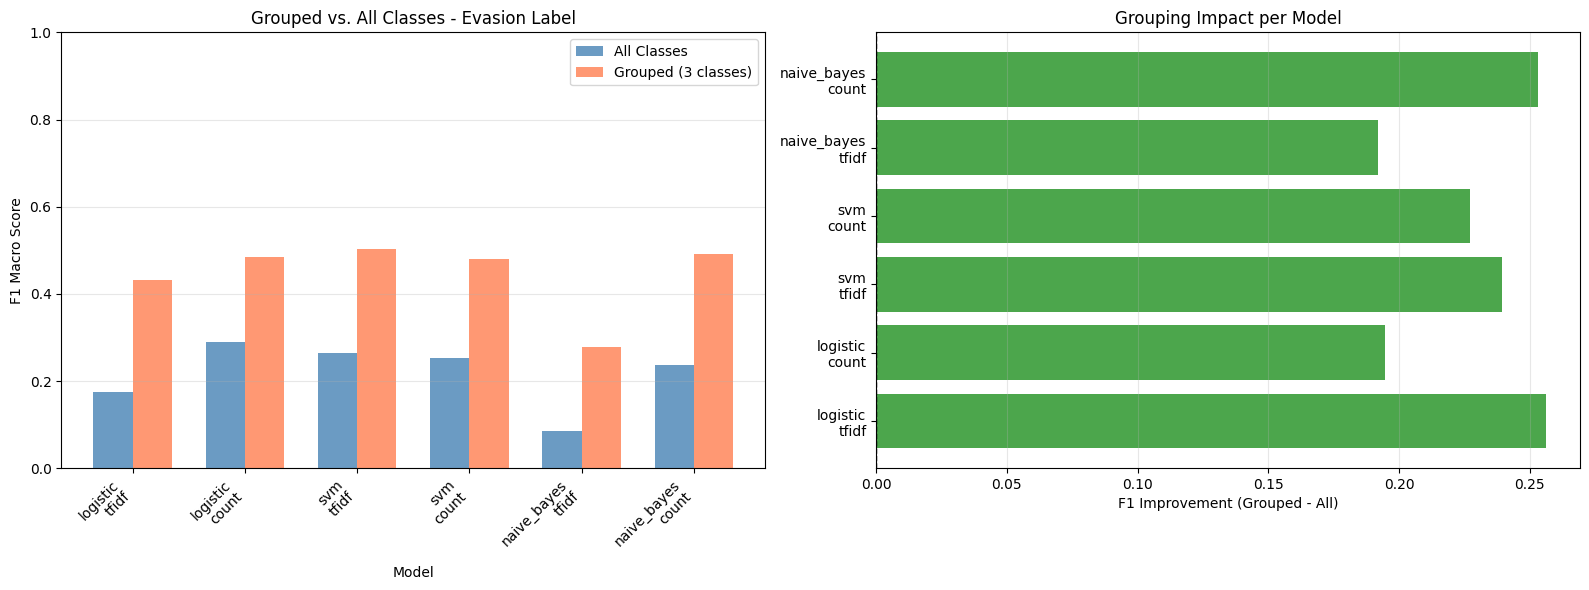


Conclusion:
✓ Grouping classes improves performance on average by 0.2270


In [7]:
# Prepare data for comparison plot
comparison_data = []

for clf in classifiers:
    for vec in vectorizers:
        model_name = f"{clf}\n{vec}"
        
        f1_all = df_evasion[
            (df_evasion['classifier'] == clf) & 
            (df_evasion['vectorizer'] == vec) & 
            (df_evasion['class_strategy'] == 'all_classes')
        ]['f1_macro'].values[0]
        
        f1_grouped = df_evasion[
            (df_evasion['classifier'] == clf) & 
            (df_evasion['vectorizer'] == vec) & 
            (df_evasion['class_strategy'] == 'grouped')
        ]['f1_macro'].values[0]
        
        comparison_data.append({
            'model': model_name,
            'all_classes': f1_all,
            'grouped': f1_grouped,
            'improvement': f1_grouped - f1_all
        })

df_comparison = pd.DataFrame(comparison_data)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot comparing F1 scores
x = np.arange(len(df_comparison))
width = 0.35

ax1.bar(x - width/2, df_comparison['all_classes'], width, label='All Classes', alpha=0.8, color='steelblue')
ax1.bar(x + width/2, df_comparison['grouped'], width, label='Grouped (3 classes)', alpha=0.8, color='coral')

ax1.set_xlabel('Model')
ax1.set_ylabel('F1 Macro Score')
ax1.set_title('Grouped vs. All Classes - Evasion Label')
ax1.set_xticks(x)
ax1.set_xticklabels(df_comparison['model'], rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim(0, 1.0)

# Improvement plot
colors = ['green' if x > 0 else 'red' for x in df_comparison['improvement']]
ax2.barh(df_comparison['model'], df_comparison['improvement'], color=colors, alpha=0.7)
ax2.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax2.set_xlabel('F1 Improvement (Grouped - All)')
ax2.set_title('Grouping Impact per Model')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('figures/phase3_grouped_vs_all_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nConclusion:")
if df_comparison['improvement'].mean() > 0:
    print(f"✓ Grouping classes improves performance on average by {df_comparison['improvement'].mean():.4f}")
else:
    print(f"✗ Grouping classes decreases performance on average by {abs(df_comparison['improvement'].mean()):.4f}")

## Export Results

In [ ]:
# # Save all results to CSV
# df_clarity.to_csv('results/phase3_clarity_results.csv', index=False)
# df_evasion.to_csv('results/phase3_evasion_results.csv', index=False)
# df_comparison.to_csv('results/phase3_grouped_vs_all.csv', index=False)

# print("\nResults exported to results/ directory")
# print("\nPhase 3 complete! ✓")